### Training a corpus-wide RMN with tfidf embeddings

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [186]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")

In [3]:
from document import load_generic_documents
from constant import DOC_GEN_PATH, MIN_SESSION, MAX_SESSION
from subject import subject_keywords

sessions = list(range(MIN_SESSION, MAX_SESSION+1))

In [4]:
from helper import *
from rmn import *
from rmn_data_generator import RMN_DataGenerator
from rmn_analyzer import RMN_Analyzer

In [5]:
# load embedding tools
generic_tools_path = "/home/rocassius/gen-data/tools/generic_tools"
prayer_tools_path = "/home/rocassius/gen-data/tools/prayer_tools"

global_embedding_matrix = load_pickled_object(os.path.join(prayer_tools_path, "embedding_matrix_wg"))
global_tokenizer_dict = load_pickled_object(os.path.join(prayer_tools_path, "tokenizer_dict_wg"))

In [6]:
docs_df = load_generic_documents([111], DOC_GEN_PATH)

In [7]:
docs_df.shape

(87238, 9)

In [400]:
data_df = docs_df.sample(500)

In [372]:
local_models_path = "/home/rocassius/gen-data/models"

In [373]:
rmn = RigidRMN()
rmn.load_rmn("PoliteFinish", local_models_path)
rmn.infer_embedding_matrix = global_embedding_matrix
rmn.infer_tokenizer_dict = global_tokenizer_dict

In [374]:
data_df

,speakerid,lastname,firstname,chamber,state,gender,party,document,session
0,111118060,BOEHNER,JOHN,H,OH,M,R,Madam Speaker. Leader HOYER. fellow Members. a...,111
1,111118060,BOEHNER,JOHN,H,OH,M,R,is right for our country. Republicans will ext...,111
2,111120160,LARSON,JOHN,H,CT,M,D,for your nomination this morning. Thank you to...,111
3,111120160,LARSON,JOHN,H,CT,M,D,as grave as our country has faced in generatio...,111
4,111120160,LARSON,JOHN,H,CT,M,D,any longer for us to move from the depths of a...,111
...,...,...,...,...,...,...,...,...,...
87233,111121510,THOMPSON,MIKE,H,CA,M,D,Madam Speaker. I rise today to honor Mr. Steph...,111
87234,111120060,KING,STEVE,H,IA,M,R,Reclaiming my time and thanking the gentlelady...,111
87235,111120060,KING,STEVE,H,IA,M,R,one single county in America somewhere? They w...,111
87236,111120060,KING,STEVE,H,IA,M,R,applaud every farmer. black or white or Native...,111


In [487]:
#====================#
#=*= RMN Analyzer =*=#
#====================#

# Class for analyzing an RMN

import numpy as np
import pandas as pd
from analysis import *

# variable constants
SUB = 'subject'
SPEAK = 'speakerid'
PARTY = 'party'
SESS = 'session'
TOPIC = 'topic'
# party constants
R = 'R'
D = 'D'
# metric constants
JS = 'js'
HH = 'hh'
EN = 'entr'
N_REC = 'n_records'
N_NAN = 'n_nan_preds'

TP = 'topic_use'
PL = 'placebo'


class RMN_Analyzer(object):
    """Class for Analyzing an RMN with respect to a dataset
    """
    
    def __init__(self, rmn, df):
        """
        Args:
        - rmn: (RMN) the RMN to be used for analysis
        - df : (DataFrame) the dataframe to analyze
        """
        
        'Initialization'
        self.rmn = rmn
        self.df = df.reset_index(drop=True)
        self.topic_preds = None
        self.y_preds = None
        
        self.topic_nns = None
        self.topic_coherence = None
        
        
    @property
    def index(self):
        return self.df.index
        
    
    def predict_topics(self, use_generator=False, k_primary_topics=5):
        """Computes the topic predictions for all observations
        """
        # predict topics
        self.topic_preds = self.rmn.predict_topics(self.df, use_generator)
        
        # dataframe of first k topics for each record
        primary_topics = self.primary_topics({}, k_primary_topics)
        primary_cols = [TOPIC + str(i) for i in range(1, k_primary_topics+1)]
        primary_df = pd.DataFrame(primary_topics, columns=primary_cols)
        
        # update analyzer dataframe
        self.df = self.df.join(primary_df)
        
    
    def predict_y(self, use_generator=True):
        """Computes the sentence vector predictions for all observations
        """
        self.y_preds = self.rmn.predict_y(self.df, use_generator)
        
        
    def sample_indices(self, indices, n):
        """Returns a SRR of the indices provided
        """
        return np.random.choice(indices, n, replace=True)

    
    def bool_subset(self, col, value):
        """
        Returns a boolean vector for each observation in the
        dataframe indicating whether it meets the col == value condition
        """
        assert col in self.df.columns
        return self.df[col] == value
    
    
    def bool_index(self, conditions):
        """
        Returns a boolean vector for each observation in the
        dataframe indicating whether it meets all conditions
        
        Args:
        - conditions: (dict) dictionary of conditions
        
        Returns: 
        - pandas series of booleans indicating where all 
          of the conditions hold
        """
        # initialize bool index
        bool_index = (pd.Series(True)
                      .repeat(self.index.shape[0])
                      .reset_index(drop=True))
        
        for col, val in conditions.items():
            bool_index = bool_index & self.bool_subset(col, val)
            
        return bool_index
    
    
    def cond_index(self, conditions):
        """Returns indices of records meeting the conditions
        """
        return self.index[self.bool_index(conditions)]
    
    
    def n_records(self, conditions={}):
        """Returns the number of records meetings the conditions
        """
        return len(self.cond_index(conditions))
    
    
    def n_nan_preds(self, conditions={}):
        """Returns the number of records which have nan predictions
        """
        cond_index = self.cond_index(conditions)
        return np.isnan(self.topic_preds[cond_index].sum(axis=-1)).sum().item()
    
    
    def compute_JS(self, index_A, index_B, omit_topics=[], base=2):
        """
        Computes the mean pair-wise JS divergence and associated CI
        between indices in index_A and indices in index_B
        """
        p_A = np.delete(self.topic_preds[index_A], omit_topics, axis=-1)
        p_B = np.delete(self.topic_preds[index_B], omit_topics, axis=-1)
        print(p_B.shape)
        js_list = [jensenshannon(p, q, base) for p, q in zip(p_A, p_B)]
        
        return mean_CI(js_list)
        
        
    def compute_HH(self, index):
        """
        Computes the mean HH index and associated CI between
        indices in index_A and indices in index_B
        """
        p = self.topic_preds[index]
        hh_list = [hh_index(q) for q in p]
        
        return mean_CI(hh_list)
    
    
    def topic_use_RD_js(self, conditions={}):
        """Returns the JS divergence of the R and D topic use distributions
        """
        R_topic_use = self.topic_use({**conditions, **{PARTY: R}})
        D_topic_use = self.topic_use({**conditions, **{PARTY: D}})
        
        return jensenshannon(R_topic_use, D_topic_use)
    
    
    def topic_use_placebo_js(self, conditions={}, n=20):
        """Returns a placebo JS divergence of the R and D topic use distributions
        """
        # get original parties
        cond_index = self.cond_index(conditions)
        party = self.df.loc[cond_index][PARTY]
        
        js_list = []
        for _ in range(n):
            # permute party labels
            self.df[PARTY][cond_index] = np.random.permutation(party)
            # compute associated js
            js = self.topic_use_RD_js(conditions)
            js_list.append(js)
        
        # restore party labels
        self.df[PARTY][cond_index] = party
        
        return mean_CI(js_list)
        
    
    def topic_use_hh(self, conditions={}):
        """Returns the HH-index of the RD topic use distributions
        """
        return hh_index(self.topic_use(conditions))
    
    
    def inter_party_js(self, conditions, n, omit_topics=[]):
        """
        Returns the estimated inter party JS divergence and a CI.
        
        Computes the inter party JS divergence between 
        Republicans and Democrats on a given subject
        
        Args:
        - subject: (str) subject to examine
        - n      : (int) sample size
        
        Returns: a numpy array of length 3, where
        - 0 is the mean divergence point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # find R and D indicies on the subject
        index_R = self.cond_index({**conditions, **{PARTY: R}})
        index_D = self.cond_index({**conditions, **{PARTY: D}})
        
        # return None if indices are insufficient
        if len(index_R)==0 or len(index_D)==0:
            return None
        
        # sample 
        samp_index_R = self.sample_indices(index_R, n)
        samp_index_D = self.sample_indices(index_D, n)
    
        return self.compute_JS(samp_index_R, samp_index_D, omit_topics)
    
    
    def group_js(self, conditions, n, omit_topics=[]):
        """
        Returns the estimated mean JS divergence and a CI
        
        Estimates the average JS divergence between any two documents of
        a group defined by the conditions. A document by speaker _i_ is 
        never compared to another document by speaker _i_.
        
        
        Args:
        - conditions: (dict) dictionary of conditions
        - n         : (int) sample size
        
        Returns: a numpy array of length 3, where index...
        - 0 is the mean divergence point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # find indicies of party on the subject
        cond_index = self.cond_index(conditions)
        
        # Return none if there are fewer than 2 speakers
        if self.df.loc[cond_index][SPEAK].nunique() < 2:
            return None
        
        # Sample index pairs
        index_AB = []
        while len(index_AB) < n:
            a_b = self.sample_indices(cond_index, n=2)
            # include samples whose speakers are different
            if self.df.loc[a_b][SPEAK].nunique() == 2:
                index_AB.append(a_b)
        
        index_AB = np.asarray(index_AB)
        assert index_AB.shape == (n, 2)
        
        # get indices for each group
        index_A, index_B = index_AB[:,0], index_AB[:,1]
        
        return self.compute_JS(index_A, index_B, omit_topics)
    
    
    def group_hh(self, conditions={}, n=None):
        """
        Returns the estimated mean HH index and a CI
        
        Estimates the average Herfindahl–Hirschman Index 
        of all records meetings the conditons.
        
        Args:
        - subject: (str) subject to examine
        - party  : (str) party of interest
        - n      : (int) sample size
        
        Returns: a numpy array of length 3, where index...
        - 0 is the mean index point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # indicies meeting the conditions
        cond_index = self.cond_index(conditions)
        
        # return None if indices are insufficient
        if len(cond_index)==0:
            return None
        
        if n is None:
            return self.compute_HH(cond_index)
        else:
            samp_index = self.sample_indices(cond_index, n)
            return self.compute_HH(samp_index)
        
        
    def analyze_subset(self, conditions, n=30):
        """
        Returns a dictionary of analysis metrics for the subset 
        of records defined by the conditions.
        
        Note: It is recommended conditions be on subject
        
        Args:
        - conditions: (dict) dictionary of conditions
        - n         : (int) sample size for estimation of metrics
        
        for the entire dataset and for each subject the following are computed:
        - n_records for all, R, D
        - n_nan_records for R, D
        - hh
        - hh_R
        - hh_D
        - js_placebo
        - js_RD
        
        Returns: a dictionary of metrics
        """
        # R and D added conditions
        conditions_R = {**conditions, **{PARTY: R}}
        conditions_D = {**conditions, **{PARTY: D}}
        
        # annotation tags
        _R = '_' + R
        _D = '_' + D
        _RD = _R + D
        _PL = '_'+ PL
        
        metrics = {
            # n records in data
            N_REC:    self.n_records(conditions),
            N_REC+_R: self.n_records(conditions_R),
            N_REC+_D: self.n_records(conditions_D),
            N_NAN+_R: self.n_nan_preds(conditions_R),
            N_NAN+_D: self.n_nan_preds(conditions_D),
            # HH Topic Use Metrics
            HH:     self.topic_use_hh(conditions),
            HH+_R:  self.topic_use_hh(conditions_R),
            HH+_D:  self.topic_use_hh(conditions_D),
            # JS Topic Use Metrics
            JS+_RD: self.topic_use_RD_js(conditions),
            JS+_PL: self.topic_use_placebo_js(conditions, n),
            # Top Use Metrics
            TP:    self.topic_use(conditions, as_tuples=True),
            TP+_R: self.topic_use(conditions_R, as_tuples=True),
            TP+_D: self.topic_use(conditions_D, as_tuples=True)
        }
        
        return metrics        
        
    
        
    def analyze(self, n):
        """
        Returns a dictionary of analysis metrics at the subject level
        and at the session level (assuming self.df is the data of a
        single session).
        
        Args:
        - n: (int) sample size for estimation of metrics
        
        Returns: a dictionary of metrics
        """
        # analyze entire session dataset
        dataset_metrics = self.analyze_subset(conditions={}, n=n)
        
        # analyze by subject
        topic_metrics = {}
        for t in range(self.rmn.num_topics):
            topic_metrics[t] = self.analyze_subset({TOPIC+str(1): t}, n)
        
        metrics = {'dataset': dataset_metrics, 
                   'topics' : topic_metrics}
        
        return metrics
    
    
    def shannon_entropy(self, conditions={}):
        """Returns the Shannon Entropy of topic predictions meeting conditions
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        return shannon_entropy(self.topic_preds[self.cond_index(conditions)])
    
    
    def mean_entropy(self, conditions={}):
        """Returns the mean entropy of topic predictions meeting condiditons
        """
        return np.nanmean(self.shannon_entropy(conditions))
        
    
    def first_topic_counts(self, conditions={}):
        """
        Returns a leaderboard of topics and how many times they 
        are the primary topic associated with a document.
        """
        if self.topic_preds is None:
            self.predict_topics()
           
        cond_index = self.cond_index(conditions)
        topic_counts = pd.Series(np.argmax(self.topic_preds[cond_index], axis=-1)).value_counts()
        
        return topic_counts
    
    
    def topic_use(self, conditions={}, as_tuples=False):
        """
        Returns a leaderboard of topics based on the percentage of 
        total weight given to them in all of the documents
        """
        cond_index = self.cond_index(conditions)
        topic_sums = pd.Series(np.nansum(self.topic_preds[cond_index], axis=0))
        topic_use = topic_sums.sort_values(ascending=False) / topic_sums.sum()
        
        if not as_tuples:
            return topic_use
        else:
            return list(topic_use.iteritems())
    
    
    def primary_topics(self, conditions={}, k=5):
        """Returns top k most prominent topics for documents
        """
        cond_index = self.cond_index(conditions)
        primary_topics = np.flip(np.argsort(self.topic_preds[cond_index]), axis=-1)[:,:k]
        
        return primary_topics
    
    
    def find_topic_nns(self):
        """Finds the nearest neighbors of the rmn's topics
        """
        self.topic_nns = np.array(self.rmn.inspect_topics())
      
    
    def find_topic_coherence(self, k=5):
        """Updates the topic coherence scores of the 
        """
        W = self.rmn.infer_embedding_matrix
        word_index = self.rmn.infer_tokenizer_dict['word_index']
        coherence_scores = [word_coherence(np.array(t)[:5,0], word_index, W) 
                            for t in self.topic_nns]
        
        self.topic_coherence = pd.Series(coherence_scores).sort_values(ascending=False)
    
    @property
    def topic_nn_sim(self):
        return pd.Series(self.topic_nns[:,0,1]).sort_values(ascending=False)
    
    
    def sample_records(self, conditions, n=10):
    
        samp_index = self.cond_index(conditions)
        if len(samp_index) > n:
            samp_index = np.random.choice(samp_index, n)
            
        self.show_records(samp_index)
    
    
    def show_records(self, index):
        
        for rec in self.df.loc[index].itertuples():
            print(30*'=')
            print('SPEAKER:', rec.firstname, rec.lastname)
            print('PARTY:  ', rec.party)
            print('\n', rec.document, '\n')
            print('PRIMARY TOPICS:', rec.t1, rec.t2, rec.t3, rec.t4, rec.t5, '\n')
        
        

In [488]:
analyzer = RMN_Analyzer(rmn, data_df)

In [489]:
analyzer.predict_topics()

In [490]:
analyzer.topic_use_RD_js()

0.047595863895535294

In [492]:
analyzer.analyze_subset(conditions={}, n=50)

{'n_records': 500,
 'n_records_R': 243,
 'n_records_D': 252,
 'n_nan_preds_R': 0,
 'n_nan_preds_D': 0,
 'hh': 0.019327635,
 'hh_R': 0.022885853,
 'hh_D': 0.019910503,
 'js_RD': 0.047595863895535294,
 'js_placebo': {'mean': 0.04736034818615852,
  'lower': 0.04412617612838809,
  'upper': 0.05059452024392896},
 'topic_use': [(44, 0.0534064881503582),
  (73, 0.045800745487213135),
  (99, 0.04185986891388893),
  (4, 0.033686086535453796),
  (61, 0.028138689696788788),
  (56, 0.026195986196398735),
  (51, 0.02564600296318531),
  (29, 0.025412417948246002),
  (54, 0.023057445883750916),
  (6, 0.022978993132710457),
  (87, 0.022403741255402565),
  (2, 0.02129509299993515),
  (17, 0.0198042131960392),
  (85, 0.019705835729837418),
  (21, 0.017871195450425148),
  (43, 0.01711651310324669),
  (53, 0.016399530693888664),
  (63, 0.016269873827695847),
  (72, 0.015052909031510353),
  (1, 0.014906300231814384),
  (42, 0.014754867181181908),
  (55, 0.014714966528117657),
  (16, 0.014076264575123787),


In [474]:
analyzer.n_records(conditions={'topic1': 0})

6

In [478]:
analyzer.analyze_subset(conditions={'topic1': 50})

{'n_records': 7,
 'n_records_R': 4,
 'n_records_D': 3,
 'n_nan_preds_R': 0,
 'n_nan_preds_D': 0,
 'hh': 0.28317222,
 'hh_R': 0.19249548,
 'hh_D': 0.4497895,
 'js_placebo': 0.18758783667231624,
 'js': {'mean': 0.18543248174422317,
  'lower': 0.1463730606956924,
  'upper': 0.22449190279275388},
 'topic_use': [(50, 0.5197019577026367),
  (44, 0.05795755237340927),
  (13, 0.04819437861442566),
  (83, 0.042807407677173615),
  (82, 0.034930210560560226),
  (55, 0.02805294096469879),
  (73, 0.025796785950660706),
  (36, 0.0237609650939703),
  (16, 0.022582270205020905),
  (46, 0.020519772544503212),
  (99, 0.016109691932797432),
  (78, 0.013892816379666328),
  (15, 0.013807278126478195),
  (6, 0.01302350778132677),
  (20, 0.011371873319149017),
  (56, 0.010326167568564415),
  (85, 0.007015322335064411),
  (57, 0.006390162277966738),
  (19, 0.006292110774666071),
  (2, 0.0049164993688464165),
  (76, 0.004682950209826231),
  (7, 0.00465846061706543),
  (70, 0.004339105449616909),
  (75, 0.00419

In [454]:
analyzer.df.columns

Index(['speakerid', 'lastname', 'firstname', 'chamber', 'state', 'gender',
       'party', 'document', 'session', 'topic1', 'topic2', 'topic3', 'topic4',
       'topic5'],
      dtype='object')

In [479]:
analysis = analyzer.analyze(n=50)

In [481]:
analysis

{'dataset': {'n_records': 500,
  'n_records_R': 243,
  'n_records_D': 252,
  'n_nan_preds_R': 0,
  'n_nan_preds_D': 0,
  'hh': 0.019327635,
  'hh_R': 0.022885853,
  'hh_D': 0.019910503,
  'js_placebo': 0.047595863895535294,
  'js': {'mean': 0.0471449329050832,
   'lower': 0.04403711749568711,
   'upper': 0.0502527483144793},
  'topic_use': [(44, 0.0534064881503582),
   (73, 0.045800745487213135),
   (99, 0.04185986891388893),
   (4, 0.033686086535453796),
   (61, 0.028138689696788788),
   (56, 0.026195986196398735),
   (51, 0.02564600296318531),
   (29, 0.025412417948246002),
   (54, 0.023057445883750916),
   (6, 0.022978993132710457),
   (87, 0.022403741255402565),
   (2, 0.02129509299993515),
   (17, 0.0198042131960392),
   (85, 0.019705835729837418),
   (21, 0.017871195450425148),
   (43, 0.01711651310324669),
   (53, 0.016399530693888664),
   (63, 0.016269873827695847),
   (72, 0.015052909031510353),
   (1, 0.014906300231814384),
   (42, 0.014754867181181908),
   (55, 0.01471496652

In [444]:
analyzer.df

,speakerid,lastname,firstname,chamber,state,gender,party,document,session,topic1,topic2,topic3,topic4,topic5
0,111116380,FILNER,BOB,H,CA,M,D,I yield myself such time as I may consume. Mr....,111,99,29,36,13,69
1,111117261,KERRY,JOHN,S,MA,M,D,U.S. growth attributable to export growth rose...,111,61,44,78,83,76
2,111118640,BLUMENAUER,EARL,H,OR,M,D,Oregon. a State that has been a leader in effo...,111,85,76,61,71,46
3,111116431,CONRAD,KENT,S,ND,M,D,Madam President. I thank the Senator for his r...,111,56,21,6,4,17
4,111117660,KINGSTON,JACK,H,GA,M,R,was going to stand behind their financial trav...,111,0,7,90,70,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,111118441,WARNER,MARK,S,VA,M,D,the bankers fault. because. lets face it. a lo...,111,61,73,78,37,4
496,111117571,COBURN,THOMAS,S,OK,M,R,The fact is. it is taxes to the average Americ...,111,50,44,82,55,83
497,111117370,CANTOR,ERIC,H,VA,M,R,I thank the gentleman. Madam Speaker. I would ...,111,8,95,21,16,17
498,111120591,MURKOWSKI,LISA,S,AK,F,R,each was exemplary in his own right. Zippy Mal...,111,52,92,87,98,42


In [427]:
#analyzer.topic_use(conditions={'t1':2}, as_tuples=True)

In [431]:
analyzer.topic_use_placebo_js(n=100)

{'mean': 0.04484224379950153,
 'lower': 0.04289315849700371,
 'upper': 0.04679132910199938}

In [446]:
analyzer.topic_use_RD_js({'topic1': 39})

0.3782659409839319

In [447]:
analyzer.topic_use_placebo_js({'topic1': 39}, n=20)

{'mean': 0.25908338186789515,
 'lower': 0.22161410407220627,
 'upper': 0.296552659663584}

In [381]:
analyzer.n_records(conditions={'t1':99, 'party':'R'})

2107

In [382]:
analyzer.group_js(conditions={'t1':99}, n=10000)

(10000, 100)


{'mean': 0.4574156213819095,
 'lower': 0.4538594686914347,
 'upper': 0.4609717740723843}

In [383]:
analyzer.inter_party_js(conditions={'t1':99}, n = 10000)

(10000, 100)


{'mean': 0.4630851351549917,
 'lower': 0.45954342139026166,
 'upper': 0.4666268489197218}

In [386]:
analyzer.group_js(conditions={'t1':99}, n=40000, omit_topics=[99])

(40000, 99)


{'mean': 0.7861703658638175,
 'lower': 0.784476280806105,
 'upper': 0.78786445092153}

In [387]:
analyzer.inter_party_js(conditions={'t1':99}, n = 40000, omit_topics=[99])

(40000, 99)


{'mean': 0.7879786497352563,
 'lower': 0.7863028102840164,
 'upper': 0.7896544891864963}

In [181]:
analyzer.topic_use()

99    0.049953
73    0.045467
44    0.040340
4     0.033198
87    0.026886
        ...   
15    0.000371
74    0.000362
59    0.000325
60    0.000267
81    0.000248
Length: 100, dtype: float32

In [57]:
analyzer.find_topic_coherence()

In [58]:
analyzer.topic_coherence

24    0.975000
26    0.941406
53    0.831250
52    0.830469
98    0.828125
        ...   
8     0.387500
14    0.373828
37    0.351562
79    0.325391
60    0.216797
Length: 100, dtype: float64

In [59]:
import matplotlib.pyplot as plt

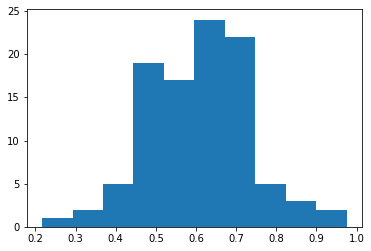

In [60]:
plt.hist(analyzer.topic_coherence)
plt.show()

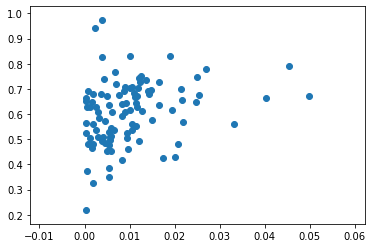

In [61]:
plt.scatter(analyzer.topic_use().sort_index(), analyzer.topic_coherence.sort_index())
plt.show()

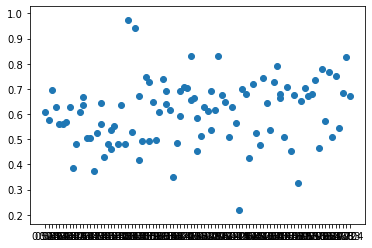

In [62]:
plt.scatter(analyzer.topic_nn_sim.sort_index(), analyzer.topic_coherence.sort_index())
plt.show()

In [33]:
analyzer.first_topic_counts()

99    54
4     49
73    49
44    41
56    31
      ..
84     1
12     1
7      1
37     1
40     1
Length: 88, dtype: int64

In [39]:
analyzer.group_js({}, n= 1000)

{'mean': 0.9440385713905827,
 'lower': 0.9365778274490637,
 'upper': 0.9514993153321014}

In [99]:
# analyzer.group_js({1:99}, n=40000)

In [35]:
analyzer.inter_party_js({'t1':99}, n=40000)

{'mean': 0.4097590455835013,
 'lower': 0.4081695207446798,
 'upper': 0.41134857042232265}

In [37]:
analyzer.group_js({'t1':99, 'party':'R'}, n=40000)

{'mean': 0.4063742454156197,
 'lower': 0.40491117034846413,
 'upper': 0.407837320482775}

In [38]:
analyzer.group_js({'t1':99, 'party':'D'}, n=40000)

KeyboardInterrupt: 

In [40]:
analyzer.n_records({'t1':99, 'party':'D'})

37

In [41]:
analyzer.n_records({'t1':99, 'party':'R'})

15

In [63]:
analyzer.sample_records({'t1':99})

SPEAKER: MICHAEL ENZI
PARTY:   R

 American jobs. The worst thing about the Reid bill is it will reduce the quality of health care we all receive. No longer will you and your employer be able to choose the health insurance that best meets your needs. The government will tell you what kind of insurance you have to buy. and if you dont. you are told the government will place a fine on you. Under the Reid bill. the government will tell your health plan which types of doctors they have to contract with. irrespective of whether that is a doctor you want or need to see. The Reid bill also traps 15 million Americans in the worst health care program in America. Approximately half the people who get the promised health care coverage under the Reid bill will get it through the broken Medicaid Program. States already use price fixing to limit how much they have to pay doctors under the Medicaid Program. That is why as many as 40 percent of all doctors will not see Medicaid patients. I have said. 

In [65]:
analyzer.topic_nns[[99, 69, 72, 29, 1]]

array([[['care', '0.704'],
        ['healthcare', '0.666'],
        ['medicaid', '0.657'],
        ['uninsured', '0.646'],
        ['medicare', '0.637'],
        ['affordable', '0.633'],
        ['prescription', '0.624'],
        ['elderly', '0.615'],
        ['health', '0.611'],
        ['beneficiaries', '0.599']],

       [['students', '0.825'],
        ['colleges', '0.792'],
        ['undergraduate', '0.788'],
        ['school', '0.781'],
        ['graduate', '0.779'],
        ['schools', '0.778'],
        ['graduates', '0.761'],
        ['classes', '0.759'],
        ['courses', '0.754'],
        ['teaching', '0.749']],

       [['organisations', '0.643'],
        ['organizations', '0.636'],
        ['nonprofit', '0.598'],
        ['nongovernmental', '0.586'],
        ['ngos', '0.564'],
        ['ministries', '0.543'],
        ['governmental', '0.539'],
        ['centres', '0.533'],
        ['libraries', '0.533'],
        ['associations', '0.533']],

       [['cancer', '0.889'],
   

In [117]:
analyzer.df

,speakerid,lastname,firstname,chamber,state,gender,party,document,session,t1,t2,t3,t4,t5
0,111118640,BLUMENAUER,EARL,H,OR,M,D,in the future. Lake Mead is less than half the...,111,41,85,62,59,13
1,111114091,DODD,CHRISTOPHER,S,CT,M,D,that vote that evening because I think it is w...,111,8,68,0,21,95
2,111119440,FORTENBERRY,JEFF,H,NE,M,R,Mr. Speaker. tomorrow we celebrate the 223rd a...,111,93,11,84,49,38
3,111120391,MCCAIN,JOHN,S,AZ,M,R,so. who will pay them. I do not know how you m...,111,56,21,6,43,4
4,111114101,DORGAN,BYRON,S,ND,M,D,(NM) Warner Whitehouse Wyden McCain McConnell ...,111,16,89,6,75,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,111120391,MCCAIN,JOHN,S,AZ,M,R,is also misleading. Does anyone really believe...,111,56,88,4,43,6
996,111118701,BOXER,BARBARA,S,CA,F,D,people do not focus on. I just explained that ...,111,55,99,82,44,83
997,111119591,GRASSLEY,CHARLES,S,IA,M,R,those assets with builtin gain are held for 10...,111,55,50,78,44,83
998,111116201,BURRIS,ROLAND,S,IL,M,D,separate fact from fiction. It is time to disc...,111,56,30,73,37,43
